# Predictive Maintenance: detect Faults from Sensors with CNN

# Library

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import os

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import *

# THE DATASET

We can image to have a hydraulic pipe system which cyclically receives impulse due to e.g. the transition of particular type of liquid in the pipeline. This phenomenon lasts 60 seconds and was measured by different sensors (Sensor Physical quantity Unit Sampling rate, PS1 Pressure bar, PS2 Pressure bar, PS3 Pressure bar, PS4 Pressure bar, PS5 Pressure bar, PS6 Pressure bar, EPS1 Motor power, FS1 Volume flow, FS2 Volume flow, TS1 Temperature, TS2 Temperature, TS3 Temperature, TS4 Temperature, VS1 Vibration, CE Cooling efficiency, CP Cooling power, SE Efficiency factor) with different Hz frequencies.

Our purpose is to predict the condition of four hydraulic components which compose the pipeline. These target condition values are annotated in the form of integer values (easy to encode) and say us if a particular component is close to fail for every cycle.

In [3]:
label = pd.read_csv(f'E:\gitlab\machine-learning\dataset\profile.txt', sep='\t', header=None)
label.columns = ['Cooler','Valve','Pump','Accumulator','Flag']

data = [f'E:\gitlab\machine-learning\dataset\TS1.txt',f'E:\gitlab\machine-learning\dataset\TS2.txt',f'E:\gitlab\machine-learning\dataset\TS3.txt',f'E:\gitlab\machine-learning\dataset\TS4.txt']
# data = [f'E:\gitlab\machine-learning\dataset\TS1.txt']
df = pd.DataFrame()

for txt in data:
    read_df = pd.read_csv(txt, sep='\t', header=None)
    df = df.append(read_df)    

print(df.shape)
df.head()

(8820, 60)


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,35.570,35.492,35.469,35.422,35.414,35.320,35.227,35.242,35.160,35.176,...,36.008,35.984,35.996,36.039,36.008,36.008,36.094,36.102,36.090,36.152
1,36.156,36.094,35.992,36.008,35.992,35.902,35.824,35.820,35.727,35.727,...,37.328,37.324,37.340,37.332,37.316,37.410,37.418,37.422,37.488,37.477
2,37.488,37.391,37.340,37.312,37.223,37.145,37.059,36.973,36.898,36.879,...,38.457,38.461,38.457,38.469,38.469,38.555,38.527,38.543,38.527,38.621
3,38.633,38.535,38.469,38.379,38.297,38.223,38.125,38.062,37.977,37.969,...,39.441,39.363,39.367,39.457,39.461,39.461,39.473,39.441,39.453,39.461
4,39.461,39.461,39.375,39.281,39.203,39.113,39.043,38.969,38.875,38.883,...,40.324,40.320,40.312,40.340,40.320,40.387,40.391,40.391,40.387,40.391


# RESHAPE DATA AMONG SENSORS

In [4]:
df = df.sort_index().values.reshape(-1,len(data),len(df.columns)).transpose(0,2,1)
df.shape

(2205, 60, 4)

saperate to become 4 again

# PLOT ORIGINAL TEMPERATURE DATA

the first cycle we have these time series from the Temperature Sensors

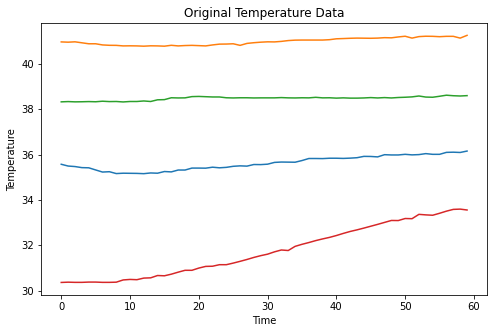

In [5]:
plt.figure(figsize=(8,5))
plt.plot(df[0])
plt.title('Original Temperature Data')
plt.ylabel('Temperature'); plt.xlabel('Time')
np.set_printoptions(False)

# LABEL DISTRIBUTION

In [6]:
label = label.Cooler
label.value_counts()

100    741
20     732
3      732
Name: Cooler, dtype: int64

# MAPPING LABEL

from true label to numeric label, to array label

In [7]:
diz_label, diz_reverse_label = {}, {}
for i,lab in enumerate(label.unique()):
    diz_label[lab] = i
    diz_reverse_label[i] = lab

print(diz_label)
print(diz_reverse_label)
label = label.map(diz_label)
y = to_categorical(label)

{3: 0, 20: 1, 100: 2}
{0: 3, 1: 20, 2: 100}


# TRAIN TEST SPLIT

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state = 42, test_size=0.2)

# SCALE DATA

In [9]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# MODEL

adopt a 1D CNN. This kind of model suits very well the analysis of time sequences of sensors and imposes to reshape the data in short fixed-length segments.

## parameter

In [10]:
num_sensors = 4
TIME_PERIODS = 60
BATCH_SIZE = 16
EPOCHS = 10

In [11]:
model_m = Sequential()
model_m.add(Conv1D(100, 6, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(100, 6, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 6, activation='relu'))
model_m.add(Conv1D(160, 6, activation='relu'))
model_m.add(GlobalAveragePooling1D(name='G_A_P_1D'))
model_m.add(Dropout(0.5))
model_m.add(Dense(3, activation='softmax'))

print(model_m.summary())
model_m.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 55, 100)           2500      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 100)           60100     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 11, 160)           96160     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 6, 160)            153760    
_________________________________________________________________
G_A_P_1D (GlobalAveragePooli (None, 160)               0         
_________________________________________________________________
dropout (Dropout)            (None, 160)               0

In [12]:
history = model_m.fit(X_train, y_train, 
                      batch_size=BATCH_SIZE, 
                      epochs=EPOCHS, 
                      validation_split=0.2, 
                      verbose=2)

Train on 1411 samples, validate on 353 samples
Epoch 1/10
1411/1411 - 12s - loss: 0.2395 - accuracy: 0.9334 - val_loss: 0.0639 - val_accuracy: 0.9773
Epoch 2/10
1411/1411 - 1s - loss: 0.1099 - accuracy: 0.9766 - val_loss: 0.0680 - val_accuracy: 0.9830
Epoch 3/10
1411/1411 - 1s - loss: 0.1242 - accuracy: 0.9731 - val_loss: 0.0676 - val_accuracy: 0.9802
Epoch 4/10
1411/1411 - 1s - loss: 0.1127 - accuracy: 0.9759 - val_loss: 0.0799 - val_accuracy: 0.9802
Epoch 5/10
1411/1411 - 1s - loss: 0.0964 - accuracy: 0.9738 - val_loss: 0.0766 - val_accuracy: 0.9858
Epoch 6/10
1411/1411 - 1s - loss: 0.1047 - accuracy: 0.9759 - val_loss: 0.0646 - val_accuracy: 0.9858
Epoch 7/10
1411/1411 - 1s - loss: 0.1052 - accuracy: 0.9759 - val_loss: 0.0846 - val_accuracy: 0.9830
Epoch 8/10
1411/1411 - 0s - loss: 0.1018 - accuracy: 0.9738 - val_loss: 0.0726 - val_accuracy: 0.9858
Epoch 9/10
1411/1411 - 1s - loss: 0.0935 - accuracy: 0.9766 - val_loss: 0.0596 - val_accuracy: 0.9858
Epoch 10/10
1411/1411 - 0s - loss:

## evaluate

In [13]:
model_m.evaluate(X_test, y_test, verbose=2)

441/441 - 0s - loss: 0.1431 - accuracy: 0.9864


[0.1431181382877824, 0.9863946]

# GET PREDICTED CLASS

In [23]:
pred_test = np.argmax(model_m.predict(X_test), axis=1)

In [16]:
print(classification_report([diz_reverse_label[np.argmax(label)] for label in y_test], 
                            [diz_reverse_label[label] for label in pred_test]))

              precision    recall  f1-score   support

           3       0.99      0.99      0.99       152
          20       0.97      0.99      0.98       135
         100       1.00      0.98      0.99       154

    accuracy                           0.99       441
   macro avg       0.99      0.99      0.99       441
weighted avg       0.99      0.99      0.99       441



In [18]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

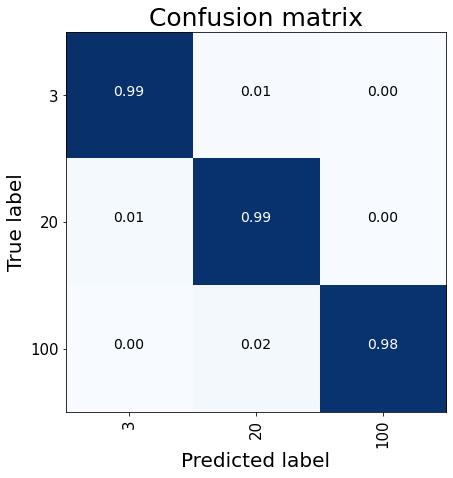

In [19]:
cnf_matrix = confusion_matrix([diz_reverse_label[np.argmax(label)] for label in y_test], 
                              [diz_reverse_label[label] for label in pred_test])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_reverse_label.values()))
plt.show()

# VISUALIZE THE RESULTS

# MAKE A MODEL FOR EMBEDDINGS 

The new model is a decoder which receives as input data in the same format of the NN we utilized for the classification task (t_periods x n_sensor for every single cycle) and return ‘prediction’ in form of embeddings coming from GlobalAveragePooling1D layer with relative dimension (a row of 160 embedding variables for every single cycle).

create new model from previous model and add G_A_P_1D layer for prediction for visualization

In [27]:
emb_model = Model(inputs=model_m.input, outputs=model_m.get_layer('G_A_P_1D').output)
emb_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 60, 4)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 100)           2500      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 100)           60100     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 11, 160)           96160     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 6, 160)            153760    
_________________________________________________________________
G_A_P_1D (GlobalAveragePooli (None, 160)               0     

# EXTRACT EMBEDDINGS

In [28]:
serie_features = emb_model.predict(X_test)

# VISUALIZE EMBEDDINGS

Computing the prediction with our encoder on the test data, adopting a technique to reduce dimensions (like PCA or T-SNE) and plotting the results 

In [29]:
tsne = TSNE(n_components=2, random_state=42, n_iter=300, perplexity=5)
T = tsne.fit_transform(serie_features)

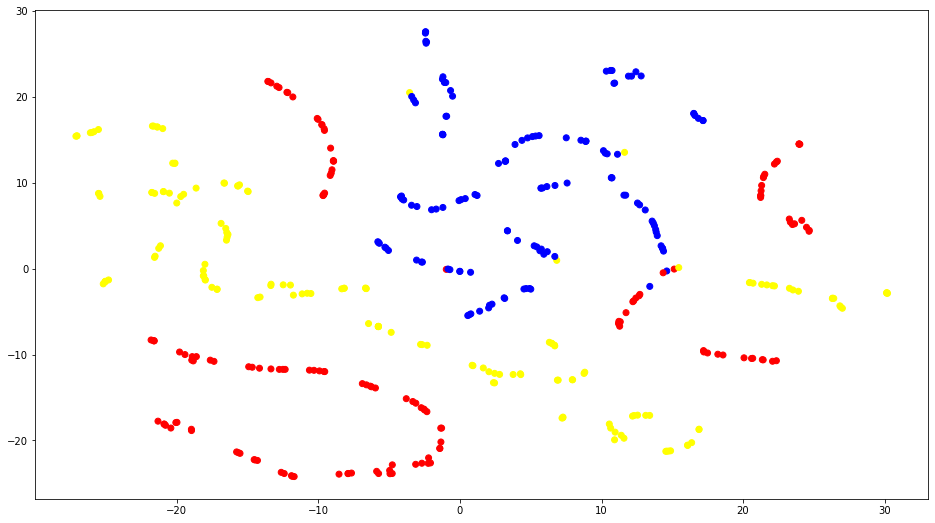

In [30]:
plt.figure(figsize=(16,9))
colors = {0:'red', 1:'blue', 2:'yellow'}
plt.scatter(T.T[0], T.T[1], c=[colors[i] for i in np.argmax(y_test, axis=1)]) 
plt.show()